In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import the inception model  
from tensorflow.keras.applications.vgg16 import VGG16


pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [4]:
def data_summary(main_path):
    
    yes_path = main_path+'yesreal'
    no_path = main_path+'noreal'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 
    
augmented_data_path = '/content/drive/My Drive/trial1/augmented data1/'    
data_summary(augmented_data_path)

Number of examples: 2064
Percentage of positive examples: 52.56782945736434%, number of pos examples: 1085
Percentage of negative examples: 47.43217054263566%, number of neg examples: 979


In [5]:
print("The number of MRI images in the training set labelled 'yes':", len(os.listdir('/content/drive/My Drive/trial1/augmented data1/training/yes1')))
print("The number of MRI images in the test set labelled 'yes':", len(os.listdir('/content/drive/My Drive/trial1/augmented data1/testing/yes1')))
print("The number of MRI images in the training set labelled 'no':", len(os.listdir('/content/drive/My Drive/trial1/augmented data1/training/no1')))
print("The number of MRI images in the test set labelled 'no':", len(os.listdir('/content/drive/My Drive/trial1/augmented data1/testing/no1')))

The number of MRI images in the training set labelled 'yes': 868
The number of MRI images in the test set labelled 'yes': 217
The number of MRI images in the training set labelled 'no': 783
The number of MRI images in the test set labelled 'no': 196


In [6]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
x = layers.Dropout(0.3)(pre_trained_model.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["acc"])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
TRAINING_DIR = "/content/drive/My Drive/trial1/augmented data1/training"
train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=64, 
                                                    class_mode='binary', 
                                                    target_size=(150, 150))
VALIDATION_DIR = "/content/drive/My Drive/trial1/augmented data1/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=64, 
                                                         class_mode='binary', 
                                                         target_size=(150, 150))

Found 1651 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [8]:
history = model.fit(train_generator,
                              epochs=30,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(validation_generator),
                              validation_data=validation_generator)

Epoch 1/30
26/26 [==============================] - 17s 652ms/step - loss: 0.7118 - acc: 0.5796 - val_loss: 0.4995 - val_acc: 0.8184
Epoch 2/30
26/26 [==============================] - 13s 482ms/step - loss: 0.5591 - acc: 0.7123 - val_loss: 0.4278 - val_acc: 0.7579
Epoch 3/30
26/26 [==============================] - 12s 478ms/step - loss: 0.4863 - acc: 0.7632 - val_loss: 0.3997 - val_acc: 0.8523
Epoch 4/30
26/26 [==============================] - 12s 478ms/step - loss: 0.4426 - acc: 0.7953 - val_loss: 0.3837 - val_acc: 0.7797
Epoch 5/30
26/26 [==============================] - 13s 501ms/step - loss: 0.4635 - acc: 0.7862 - val_loss: 0.3371 - val_acc: 0.8402
Epoch 6/30
26/26 [==============================] - 13s 484ms/step - loss: 0.4271 - acc: 0.7989 - val_loss: 0.3696 - val_acc: 0.8668
Epoch 7/30
26/26 [==============================] - 12s 477ms/step - loss: 0.4049 - acc: 0.8104 - val_loss: 0.3300 - val_acc: 0.8717
Epoch 8/30
26/26 [==============================] - 12s 475ms/step - 

Training Accuracy:  87.4015748500824 %
Validation Accuracy:  87.16707229614258 %
Training Loss:  0.2881373167037964
Validation Loss:  0.31191378831863403


Text(0.5, 1.0, 'Training and validation loss')

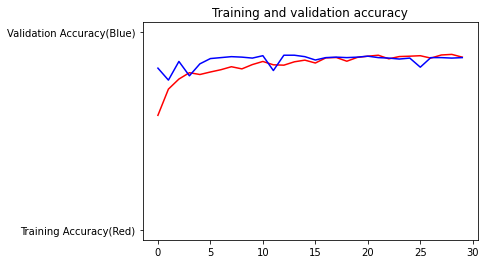

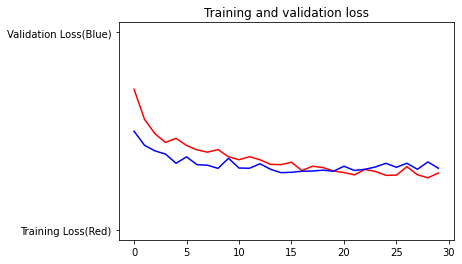

In [9]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
print("Training Accuracy: ",acc[-1]*100,"%")
print("Validation Accuracy: ",val_acc[-1]*100,"%")
print("Training Loss: ",loss[-1])
print("Validation Loss: ",val_loss[-1])
epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy(Red)")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy(Blue)")
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss(Red)")
plt.plot(epochs, val_loss, 'b', "Validation Loss(Blue)")


plt.title('Training and validation loss')